## Summarising data across repeated runs of same workload 

In [1]:
import json
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# GLOBAL VARIABLES / PARAMETERS
WORKLOAD = "WITH_ISTIO_WITH_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 5
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()","schedule()"}
PROCESSES=['containerd', 'kube-controller', 'HomeTimelineSer', 'UserMentionServ', 'envoy', 'UserTimelineSer', 'pilot-agent','calico-node', 'MediaService',  'apiserver', 'calico-typha','PostStorageServ','ComposePostServ','kube-apiserver', 'kubelet', 'mongod', 'UniqueIdService', 'openresty', 'SocialGraphServ', 'etcd', 'TextService', 'redis-server',  'UrlShortenServi', 'UserService','node', 'memcached','ip6tables','others']
COLORS=['#201923','#fcff5d','#7dfc00','#0ec434','#228c68','#8ad8e8','#235b54','#29bdab','#3998f5','#37294f','#277da7','#3750db','#f22020','#991919','#ffcba5','#e68f66','#c56133','#96341c','#632819','#ffc413','#f47a22','#2f2aa0','#b732cc','#772b9d','#f07cab','#d30b94','#edeff3','#c3a5b4','#946aa2','#5d4c86']

In [4]:
COLOR_MAP={}
for i in range(len(PROCESSES)):
    COLOR_MAP[PROCESSES[i]]=COLORS[i]


#### Identifying most important functions by count

In [5]:

def get_runs():
    runs = []
    for i in range(NUM_RUNS):
        with open(os.path.join(PARSED_OUTPUTS, f'{i}.json'), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs


Sample JSON
```json
"2016654": [
    {
      "function_name": "do_syscall_64() ",
      "time": 100134.8,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 100129.9,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 100129.6,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.862,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.561,
                      "children": []
                    }
                  ]
                }
```

In [6]:
def get_function_counts(run, recurse=False):
    count = {}

    def get_counts(function, count, recurse):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, 0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse)
    for pid in run:
        for function in run[pid]:
            get_counts(function, count, recurse)
        
    return count

def plot_counts(count, title=WORKLOAD, maxnum=20):
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x], reverse=True)[ :maxnum]
    y = [count[_] for _ in x]


    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.bar(x, y)
    plt.show()
    del x, y

In [7]:
def get_pid_mapping(file):
    pid_mapping={}
    with open(file,'r') as f:
        for line in f.readlines():
            
            pid,*name= line.split()
            if(type(name)==list):
                name=' '.join(name)
            pid_mapping[pid]=name
            
    return pid_mapping

In [8]:
def get_function_counts_per_process(run, run_no, recurse=False):
    count = {}
    process_count={}
    pids = get_pid_mapping(f'{WORKLOAD}/{run_no}.saved_cmdlines')
    def get_counts(function, count, recurse,pid):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, {})
            count[func_name][pid] = count.get(func_name).get(pid,0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse,pid)
    for pid in run:
        # count[pid]={}
        for function in run[pid]:
            get_counts(function, count, recurse,pid)
    for function,data in count.items():
        process_count[function]={}
        for pid in data:
            if pid in pids:
                process_count[function][pids[pid]]=process_count.get(function).get(pids[pid],0) + count[function][pid]
                process_count[function]['total']=process_count.get(function).get('total',0) + count[function][pid]
        if(len(process_count[function])==0):
            del process_count[function]
                
    return process_count
        
def plot_stacked_counts(count, title=WORKLOAD, maxnum=20):
    processes= set()
    for data in count.values():
        for proc in data:
            if proc != 'total':
                processes.add(proc)
    processes= sorted(list(processes))
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x]['total'], reverse=True)[ :maxnum]
    yold=[0 for _ in range(len(x))]
    plt.figure(figsize=(16, 6))
    others=[0 for _ in range(len(x))]
    for proc in processes:
        if(proc in PROCESSES):
            y=[0 for _ in range(len(x))]
            for i in range(len(x)):
                y[i] = count[x[i]].get(proc,0)
            plt.bar(x,y,bottom=yold,color=COLOR_MAP[proc],label=proc)
            yold = [yold[i] + y[i] for i in range (len(y))]
        else:
            for i in range(len(x)):
                others[i] += count[x[i]].get(proc,0)
    plt.bar(x,others,bottom=yold,color=COLOR_MAP['others'],label='others')

    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.legend()
    plt.title(title)
    plt.show()
    del x, y

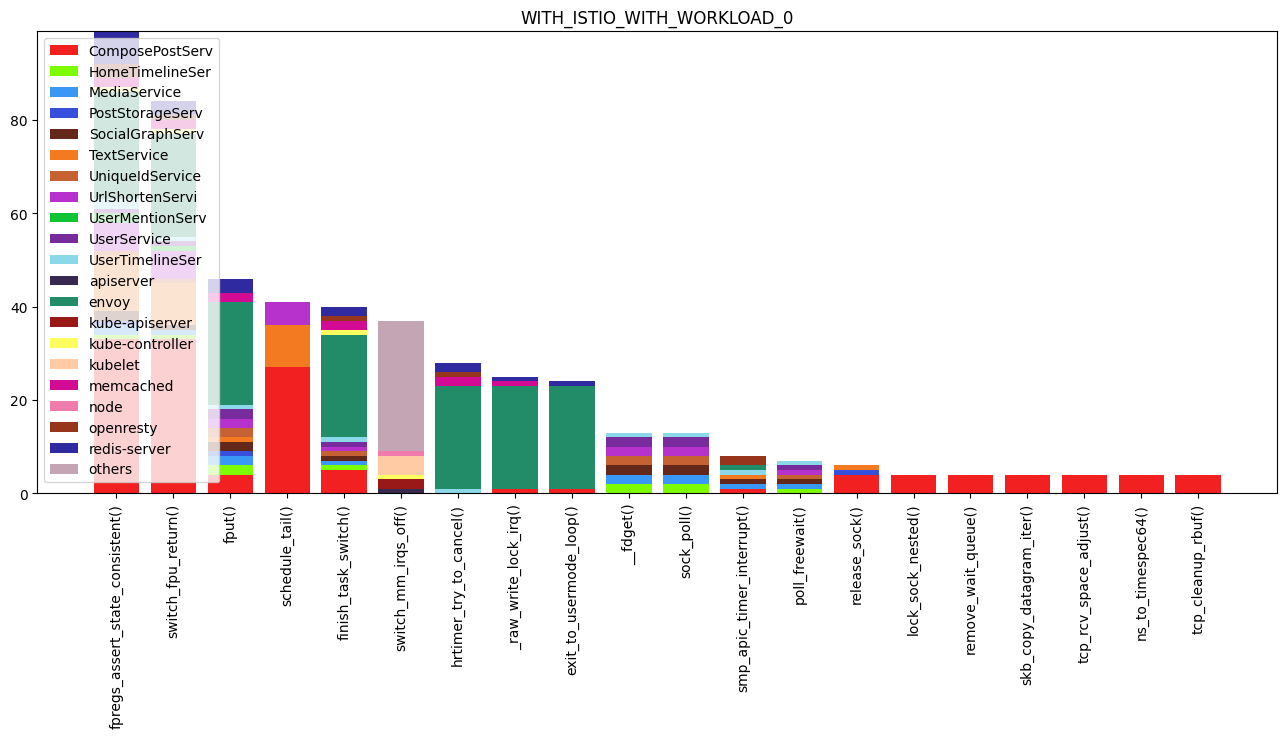

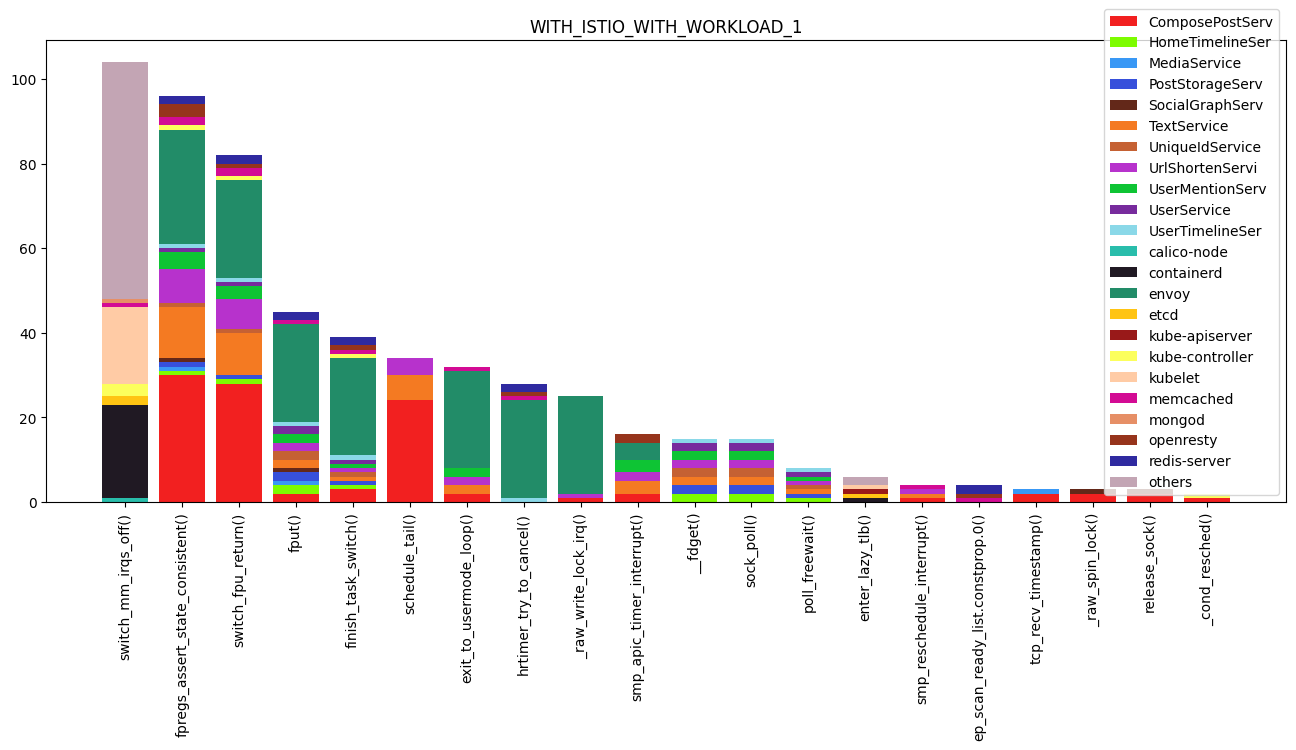

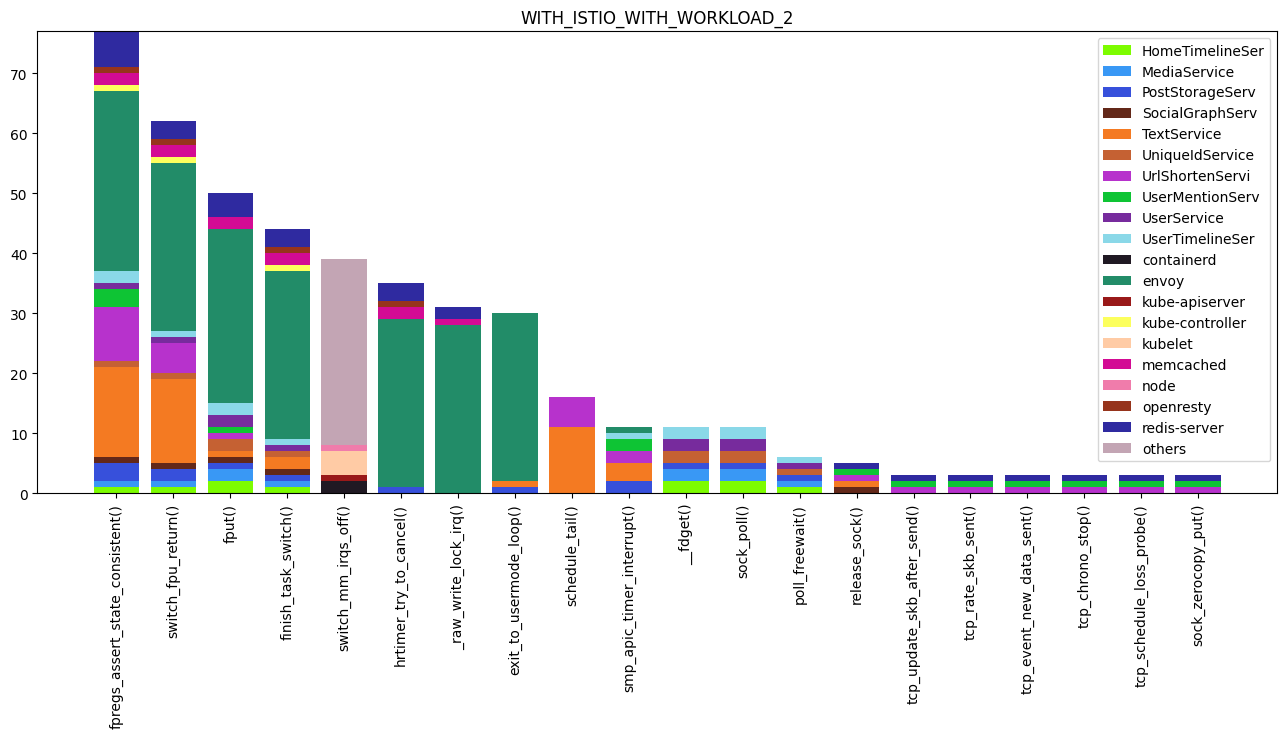

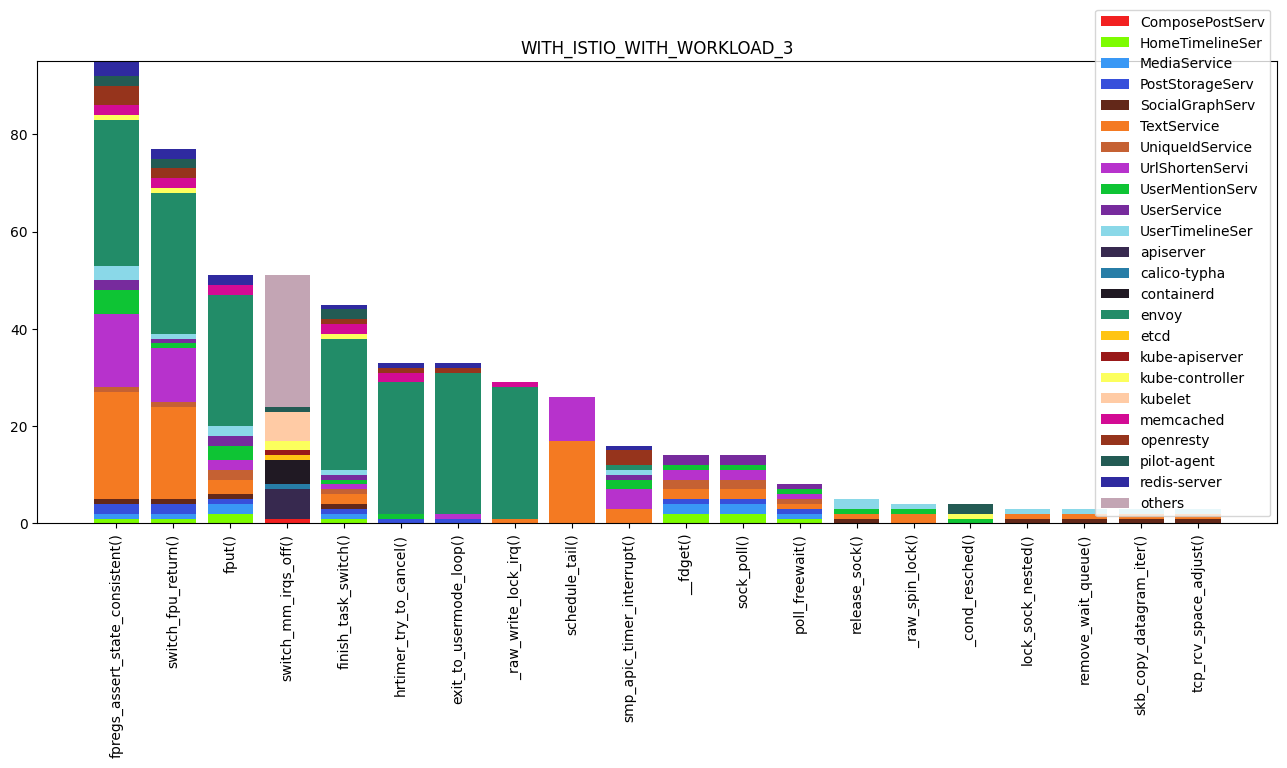

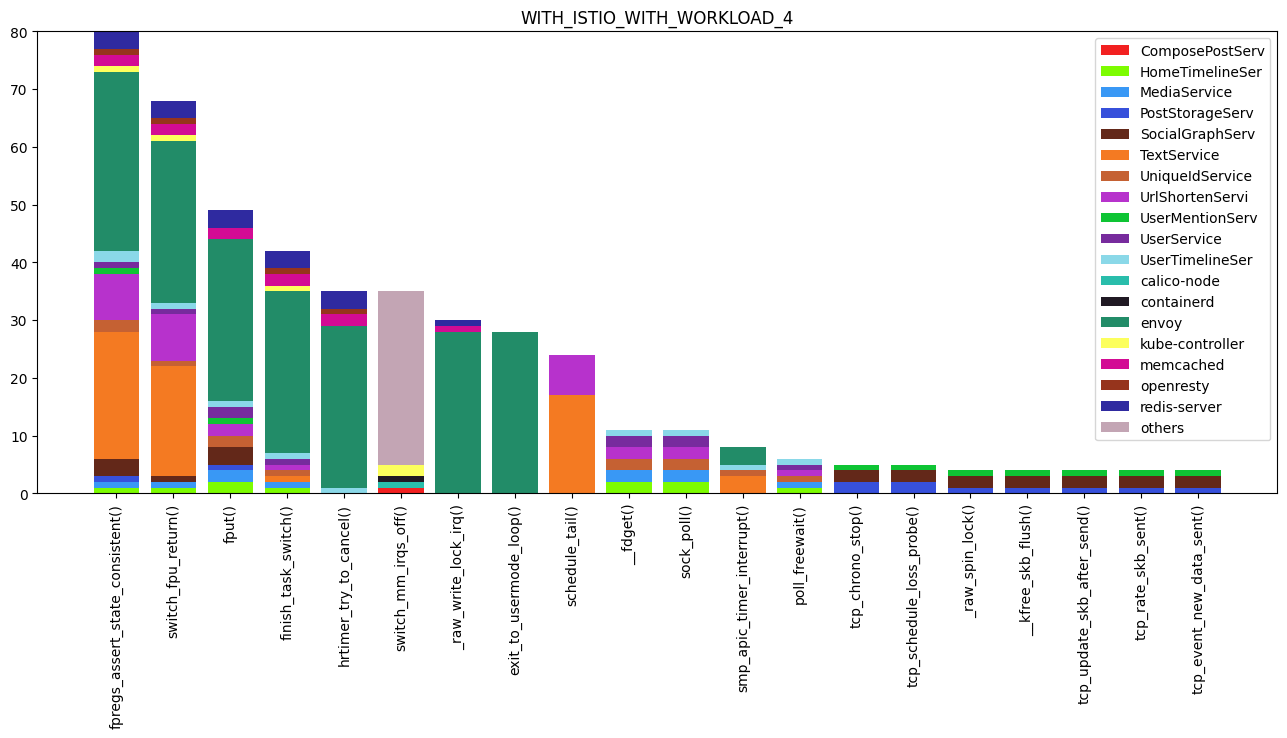

In [9]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts_per_process(runs[i],i)
    plot_stacked_counts(count, title=f"{WORKLOAD}_{i}")

Points of Note
* fpregs_assert_state_consistent() is the most called function call consistenctly
* The function call counts are identical across the runs
* There are a total of only around 10-13 functions called in the idle runs at the top level of the callgraph

#### Parsing the callgraph recursively

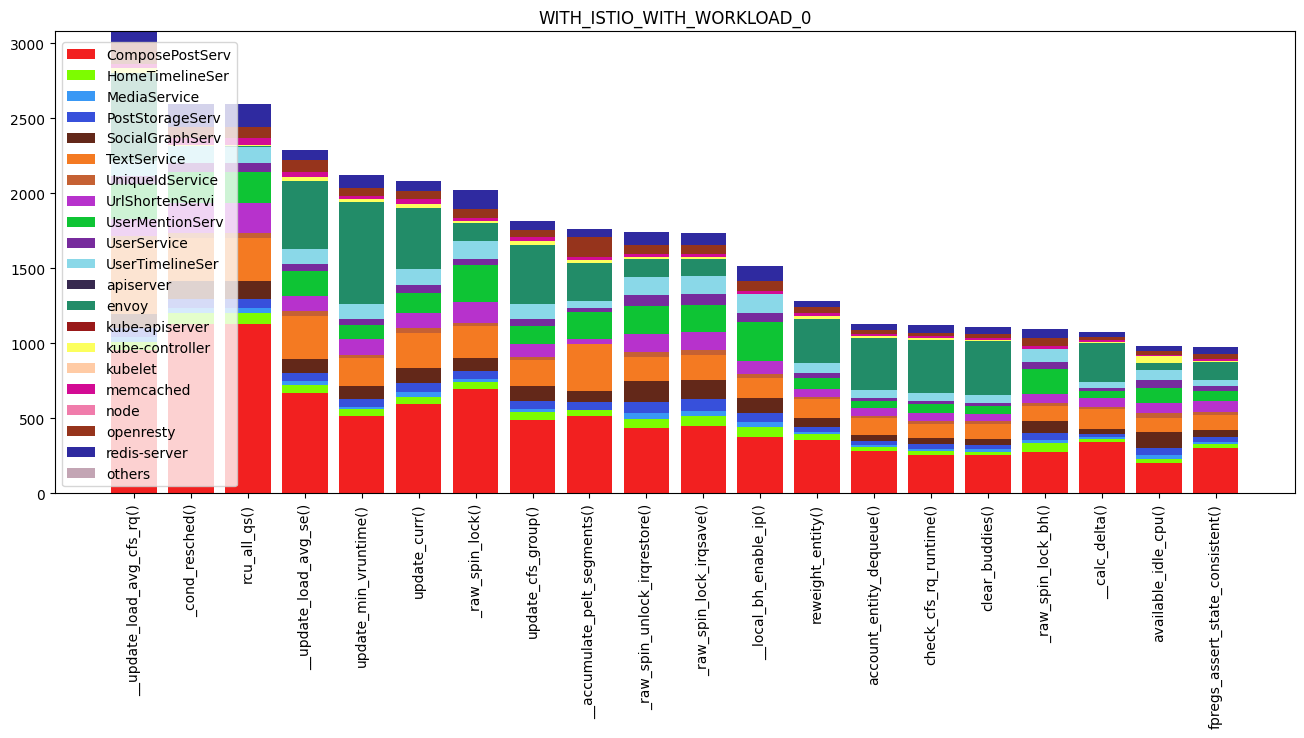

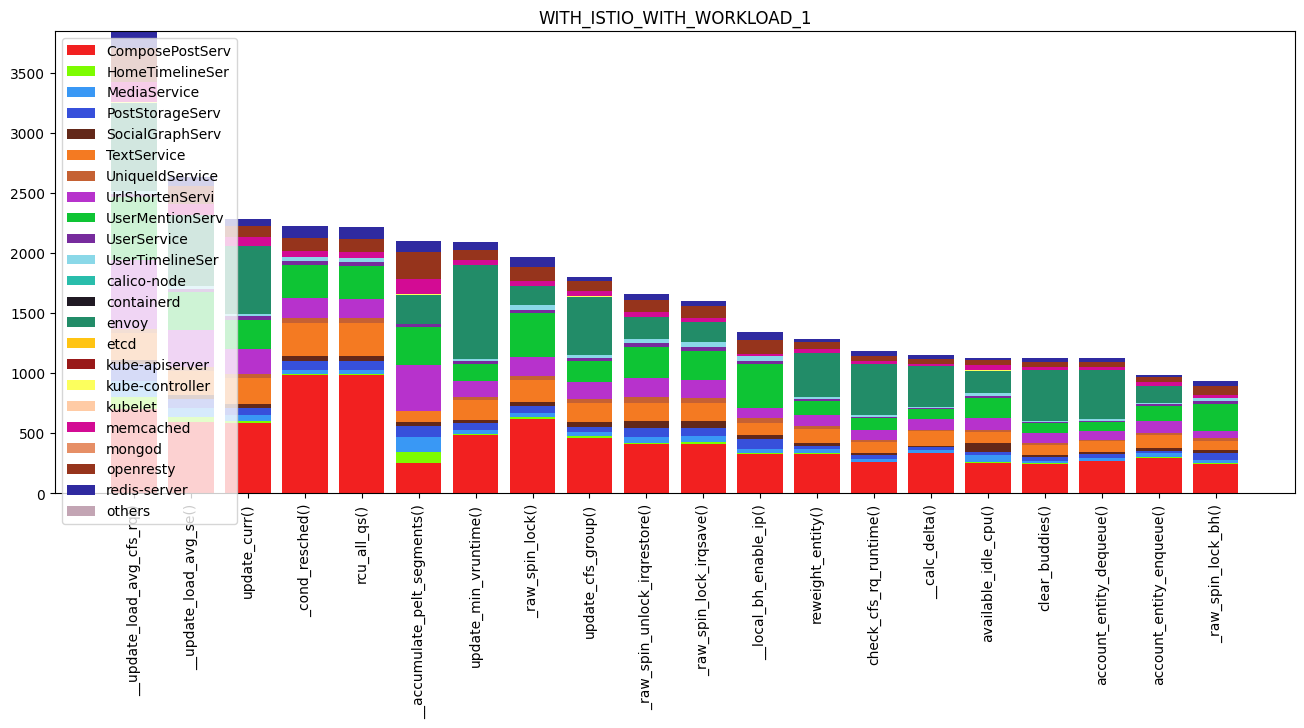

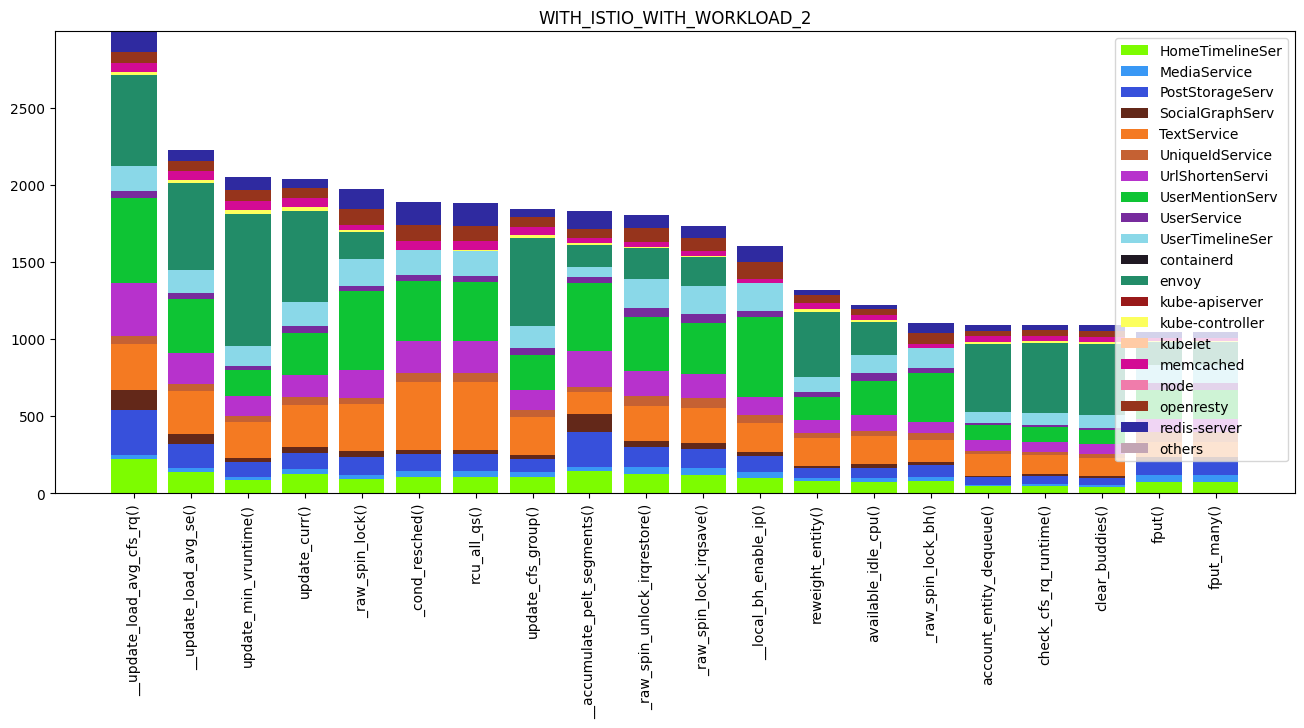

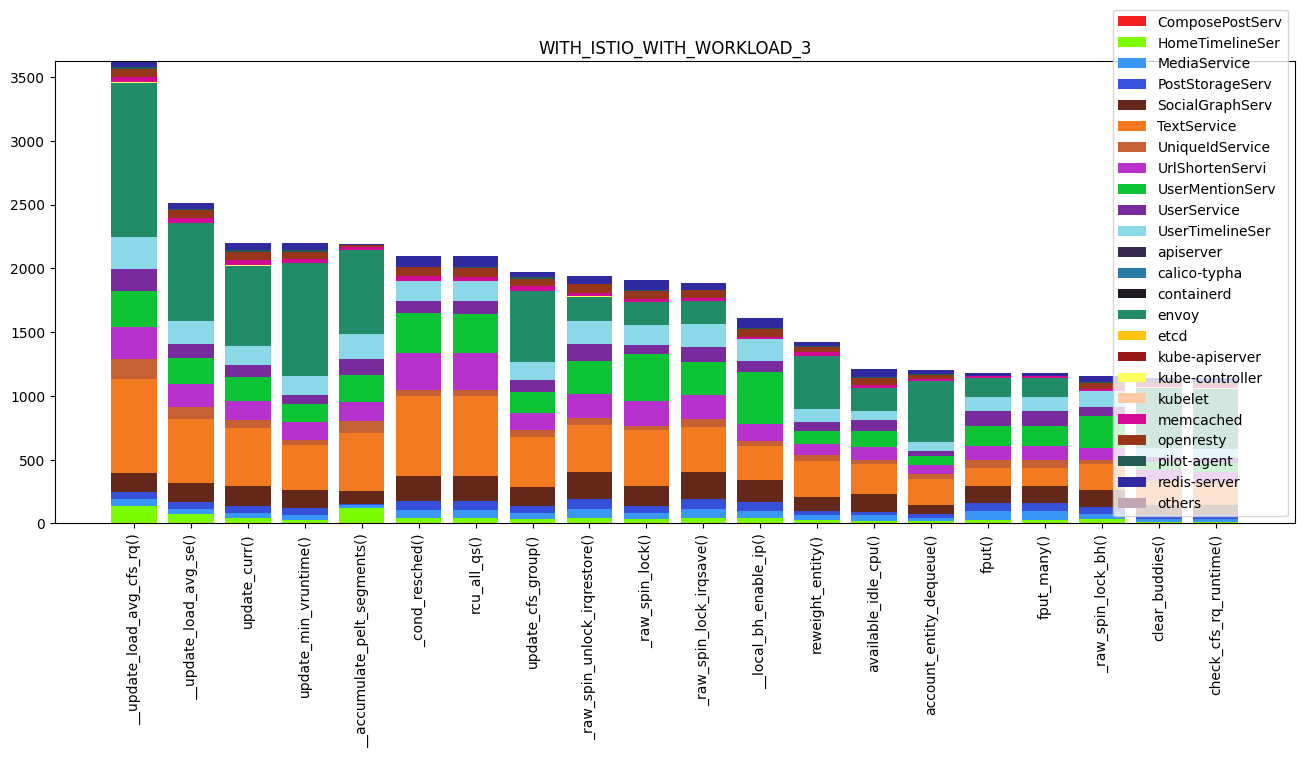

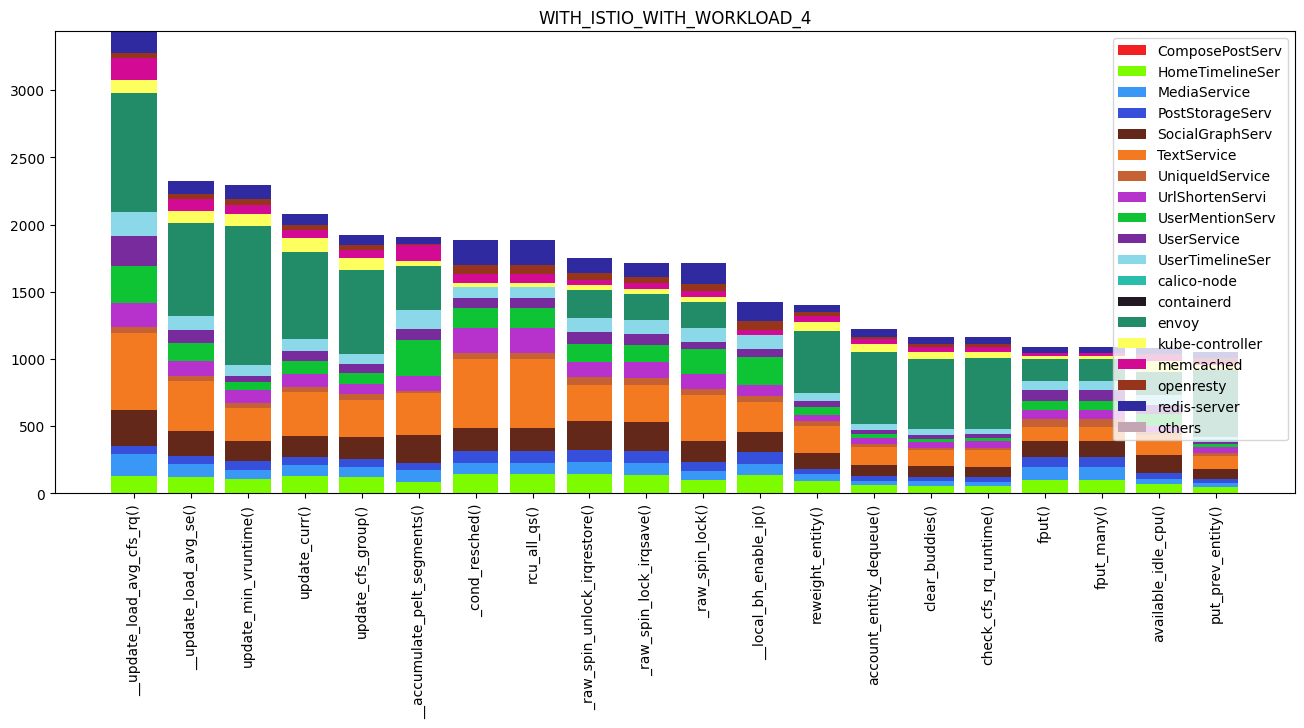

In [10]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts_per_process(runs[i],i,recurse=True)
    plot_stacked_counts(count, title=f"{WORKLOAD}_{i}")

With recursion the most called function is update_load_avg_cfs_rq() . It updates the cfs_rq's load/util averages. (completley fair scheduler's queue).

In [7]:
function_counts = [get_function_counts(run, recurse=True) for run in runs]

with open(f"pickles/function_counts/{WORKLOAD}.pickle", "wb") as f:
    pickle.dump(function_counts, file=f)

In [8]:
print(len(function_counts[0]), len(function_counts[1]), len(function_counts[2]))

1233 1317 1260


In [9]:
for i in range(NUM_RUNS):
    for j in range(NUM_RUNS):
        if i == j:
            continue

        print(f"Calls in {i} but not in {j} ", 
            set(function_counts[i].keys()).difference(set(function_counts[j].keys())), sep="\n", end="\n")
        print()

Calls in 0 but not in 1 
{'do_wp_page()', 'destroy_context_ldt()', 'get_vma_policy.part.0()', 'page_move_anon_rmap()', 'kick_ilb()', 'swake_up_locked.part.0()', 'do_async_page_fault()', 'free_pages.part.0()', 'page_add_new_anon_rmap()', 'ptep_set_access_flags()', 'free_pcp_prepare()', 'housekeeping_cpumask()', 'page_cpupid_xchg_last()', 'free_unref_page_prepare.part.0()', 'down_read_trylock()', 'reuse_swap_page()', 'mem_cgroup_try_charge()', 'vm_normal_page()', 'mem_cgroup_commit_charge()', 'do_anonymous_page()', 'queued_read_lock_slowpath()', '__handle_mm_fault()', 'swake_up_one()', 'pgd_free()', 'mem_cgroup_throttle_swaprate()', 'update_nohz_stats()', '__count_memcg_events()', 'kthread_blkcg()', 'lru_cache_add_active_or_unevictable()', 'pmd_devmap_trans_unstable()', '__page_set_anon_rmap()', '__lru_cache_add()', 'handle_mm_fault()', 'uncharge_page()', 'mem_cgroup_charge_statistics()', '__free_pages()', 'rcu_gp_kthread_wake()', 'mem_cgroup_try_charge_delay()', 'free_pages()', 'alloc_p

In [10]:
def get_count_diff(function_counts):
    count_diff = {}
    for i in range(NUM_RUNS):
        for j in range(NUM_RUNS):
            if i==j:
                continue
            count_diff[f"{i}-{j}"]= {}
            for function in function_counts[i].keys():
                lhs = function_counts[i].get(function, 0) 
                rhs = function_counts[j].get(function, 0)
                if lhs <= rhs: 
                    continue
                count_diff[f"{i}-{j}"][function] = (lhs - rhs) / lhs * 100
    return count_diff


In [11]:
diff_count = get_count_diff(function_counts=function_counts)

In [12]:
[(x, diff_count["0-1"][x]) for x in sorted(diff_count["0-1"], key=lambda x: diff_count["0-1"][x], reverse=True)]

[('__mmdrop()', 100.0),
 ('pgd_free()', 100.0),
 ('free_pages()', 100.0),
 ('free_pages.part.0()', 100.0),
 ('__free_pages()', 100.0),
 ('destroy_context_ldt()', 100.0),
 ('kick_ilb()', 100.0),
 ('housekeeping_cpumask()', 100.0),
 ('rcu_report_qs_rnp()', 100.0),
 ('rcu_gp_kthread_wake()', 100.0),
 ('swake_up_one()', 100.0),
 ('swake_up_locked.part.0()', 100.0),
 ('update_nohz_stats()', 100.0),
 ('do_async_page_fault()', 100.0),
 ('do_page_fault()', 100.0),
 ('__do_page_fault()', 100.0),
 ('down_read_trylock()', 100.0),
 ('handle_mm_fault()', 100.0),
 ('mem_cgroup_from_task()', 100.0),
 ('__count_memcg_events()', 100.0),
 ('__handle_mm_fault()', 100.0),
 ('pmd_devmap_trans_unstable()', 100.0),
 ('do_wp_page()', 100.0),
 ('vm_normal_page()', 100.0),
 ('reuse_swap_page()', 100.0),
 ('page_trans_huge_mapcount()', 100.0),
 ('page_move_anon_rmap()', 100.0),
 ('unlock_page()', 100.0),
 ('page_cpupid_xchg_last()', 100.0),
 ('ptep_set_access_flags()', 100.0),
 ('do_anonymous_page()', 100.0),
 (

In [13]:
[(x, diff_count["0-2"][x]) for x in sorted(diff_count["0-2"], key=lambda x: diff_count["0-2"][x], reverse=True)]

[('_get_random_bytes.part.0()', 100.0),
 ('crng_make_state()', 100.0),
 ('crng_fast_key_erasure()', 100.0),
 ('can_migrate_task()', 100.0),
 ('kthread_is_per_cpu()', 100.0),
 ('d_hash_and_lookup()', 100.0),
 ('full_name_hash()', 100.0),
 ('d_lookup()', 100.0),
 ('cgroup_release()', 100.0),
 ('pids_release()', 100.0),
 ('pids_cancel.constprop.0()', 100.0),
 ('posix_cpu_timers_exit()', 100.0),
 ('cleanup_timers()', 100.0),
 ('add_device_randomness()', 100.0),
 ('detach_pid()', 100.0),
 ('__change_pid()', 100.0),
 ('free_pid()', 100.0),
 ('flush_sigqueue()', 100.0),
 ('__cleanup_sighand()', 100.0),
 ('release_thread()', 100.0),
 ('put_task_struct_rcu_user()', 100.0),
 ('proc_exit_connector()', 100.0),
 ('mpol_put_task_policy()', 100.0),
 ('__put_page()', 100.0),
 ('__put_compound_page()', 100.0),
 ('PageHuge()', 100.0),
 ('__page_cache_release()', 100.0),
 ('free_compound_page()', 100.0),
 ('mem_cgroup_uncharge()', 100.0),
 ('exit_rcu()', 100.0),
 ('exit_tasks_rcu_finish()', 100.0),
 ('ta

In [14]:
[(x, diff_count["1-0"][x]) for x in sorted(diff_count["1-0"], key=lambda x: diff_count["1-0"][x], reverse=True)]

[('sched_cfs_period_timer()', 100.0),
 ('update_group_capacity()', 100.0),
 ('mempolicy_slab_node()', 100.0),
 ('__cpuset_node_allowed()', 100.0),
 ('new_slab()', 100.0),
 ('allocate_slab()', 100.0),
 ('get_random_u32()', 100.0),
 ('setup_object_debug.isra.0()', 100.0),
 ('tcp_delack_timer()', 100.0),
 ('tcp_delack_timer_handler()', 100.0),
 ('iptable_raw_hook [iptable_raw]()', 100.0),
 ('comment_mt [xt_comment]()', 100.0),
 ('mark_tg [xt_mark]()', 100.0),
 ('mark_mt [xt_mark]()', 100.0),
 ('iptable_mangle_hook [iptable_mangle]()', 100.0),
 ('iptable_filter_hook [iptable_filter]()', 100.0),
 ('conntrack_mt_v3 [xt_conntrack]()', 100.0),
 ('conntrack_mt [xt_conntrack]()', 100.0),
 ('ip_sabotage_in [br_netfilter]()', 100.0),
 ('delayed_work_timer_fn()', 100.0),
 ('__queue_work()', 100.0),
 ('get_work_pool()', 100.0),
 ('insert_work()', 100.0),
 ('blk_stat_timer_fn()', 100.0),
 ('wb_timer_fn()', 100.0),
 ('scale_up()', 100.0),
 ('rq_depth_scale_up()', 100.0),
 ('rwb_arm_timer()', 100.0),
 

In [15]:
[(x, diff_count["2-0"][x]) for x in sorted(diff_count["2-0"], key=lambda x: diff_count["2-0"][x], reverse=True)]

[('tcp_try_rmem_schedule()', 100.0),
 ('tcp_delack_timer()', 100.0),
 ('tcp_delack_timer_handler()', 100.0),
 ('__note_gp_changes()', 100.0),
 ('rcu_advance_cbs()', 100.0),
 ('rcu_segcblist_advance()', 100.0),
 ('rcu_do_batch()', 100.0),
 ('rcu_segcblist_extract_done_cbs()', 100.0),
 ('rcu_cblist_dequeue()', 100.0),
 ('dst_destroy_rcu()', 100.0),
 ('dst_destroy()', 100.0),
 ('ipv4_dst_destroy()', 100.0),
 ('i_callback()', 100.0),
 ('sock_free_inode()', 100.0),
 ('file_free_rcu()', 100.0),
 ('epi_rcu_free()', 100.0),
 ('rcu_segcblist_insert_done_cbs()', 100.0),
 ('rcu_segcblist_insert_count()', 100.0),
 ('delayed_put_pid()', 100.0),
 ('put_pid_ns()', 100.0),
 ('delayed_put_task_struct()', 100.0),
 ('__put_task_struct()', 100.0),
 ('cgroup_free()', 100.0),
 ('task_numa_free()', 100.0),
 ('security_task_free()', 100.0),
 ('yama_task_free()', 100.0),
 ('yama_ptracer_del()', 100.0),
 ('apparmor_task_free()', 100.0),
 ('exit_creds()', 100.0),
 ('key_put()', 100.0),
 ('profile_handoff_task()'

In [16]:
[(x, diff_count["2-1"][x]) for x in sorted(diff_count["2-1"], key=lambda x: diff_count["2-1"][x], reverse=True)]

[('rcu_report_qs_rnp()', 100.0),
 ('tcp_try_rmem_schedule()', 100.0),
 ('dst_destroy_rcu()', 100.0),
 ('dst_destroy()', 100.0),
 ('ipv4_dst_destroy()', 100.0),
 ('do_async_page_fault()', 100.0),
 ('do_page_fault()', 100.0),
 ('__do_page_fault()', 100.0),
 ('down_read_trylock()', 100.0),
 ('handle_mm_fault()', 100.0),
 ('mem_cgroup_from_task()', 100.0),
 ('__count_memcg_events()', 100.0),
 ('__handle_mm_fault()', 100.0),
 ('pmd_devmap_trans_unstable()', 100.0),
 ('do_wp_page()', 100.0),
 ('vm_normal_page()', 100.0),
 ('reuse_swap_page()', 100.0),
 ('page_trans_huge_mapcount()', 100.0),
 ('page_move_anon_rmap()', 100.0),
 ('unlock_page()', 100.0),
 ('page_cpupid_xchg_last()', 100.0),
 ('ptep_set_access_flags()', 100.0),
 ('__mmdrop()', 100.0),
 ('pgd_free()', 100.0),
 ('free_pages()', 100.0),
 ('free_pages.part.0()', 100.0),
 ('__free_pages()', 100.0),
 ('destroy_context_ldt()', 100.0),
 ('tw_timer_handler()', 100.0),
 ('inet_twsk_kill()', 100.0),
 ('inet_twsk_bind_unhash()', 100.0),
 ('

In [17]:
[(x, diff_count["1-2"][x]) for x in sorted(diff_count["1-2"], key=lambda x: diff_count["1-2"][x], reverse=True)]

[('sched_cfs_period_timer()', 100.0),
 ('update_group_capacity()', 100.0),
 ('_get_random_bytes.part.0()', 100.0),
 ('crng_make_state()', 100.0),
 ('crng_fast_key_erasure()', 100.0),
 ('mempolicy_slab_node()', 100.0),
 ('__cpuset_node_allowed()', 100.0),
 ('new_slab()', 100.0),
 ('allocate_slab()', 100.0),
 ('get_random_u32()', 100.0),
 ('setup_object_debug.isra.0()', 100.0),
 ('eventfd_poll()', 100.0),
 ('eventfd_read()', 100.0),
 ('process_timeout()', 100.0),
 ('iptable_raw_hook [iptable_raw]()', 100.0),
 ('comment_mt [xt_comment]()', 100.0),
 ('mark_tg [xt_mark]()', 100.0),
 ('mark_mt [xt_mark]()', 100.0),
 ('iptable_mangle_hook [iptable_mangle]()', 100.0),
 ('iptable_filter_hook [iptable_filter]()', 100.0),
 ('conntrack_mt_v3 [xt_conntrack]()', 100.0),
 ('conntrack_mt [xt_conntrack]()', 100.0),
 ('ip_sabotage_in [br_netfilter]()', 100.0),
 ('blk_stat_timer_fn()', 100.0),
 ('wb_timer_fn()', 100.0),
 ('scale_up()', 100.0),
 ('rq_depth_scale_up()', 100.0),
 ('rwb_arm_timer()', 100.0),

### Conclusion
* There is not a signifiicant difference between the counts of the various calls.
* Especially in without-istio-without-workload, most calls are seen very infrequently 
* The most frequent calls can be noted and assigned low weightage in future anlaysis

In [11]:
def get_process_latency(run, run_no, blacklist=FUNC_BLACKLIST):
    latency = {}
    process_count={}
    pids = get_pid_mapping(f'{WORKLOAD}/{run_no}.saved_cmdlines')
    print(blacklist)

    def update_latency(function,pid):
        
        # for call in data:
        func_name = function['function_name']
        if func_name not in blacklist:   
            latency[func_name] = latency.get(func_name, {})        
            latency[func_name][pid] = latency.get(func_name).get(pid,0) + function['time']
            for child in function['children']:
                    latency[func_name][pid] -= child['time']
        for child in function["children"]:
                update_latency(child,pid)

    
    for pid in run:
        for function in run[pid]:
            update_latency(function,pid)
    for function,data in latency.items():
        process_count[function]={}
        for pid in data:
            if pid in pids:
                process_count[function][pids[pid]]=process_count.get(function).get(pids[pid],0) + latency[function][pid]
                process_count[function]['total']=process_count.get(function).get('total',0) + latency[function][pid]
        if(len(process_count[function])==0):
            del process_count[function]
                

    return process_count

In [12]:
runs = get_runs()

{'do_syscall_64()', 'schedule()', 'BLANK'}
{'do_syscall_64()', 'schedule()', 'BLANK'}
{'do_syscall_64()', 'schedule()', 'BLANK'}
{'do_syscall_64()', 'schedule()', 'BLANK'}
{'do_syscall_64()', 'schedule()', 'BLANK'}


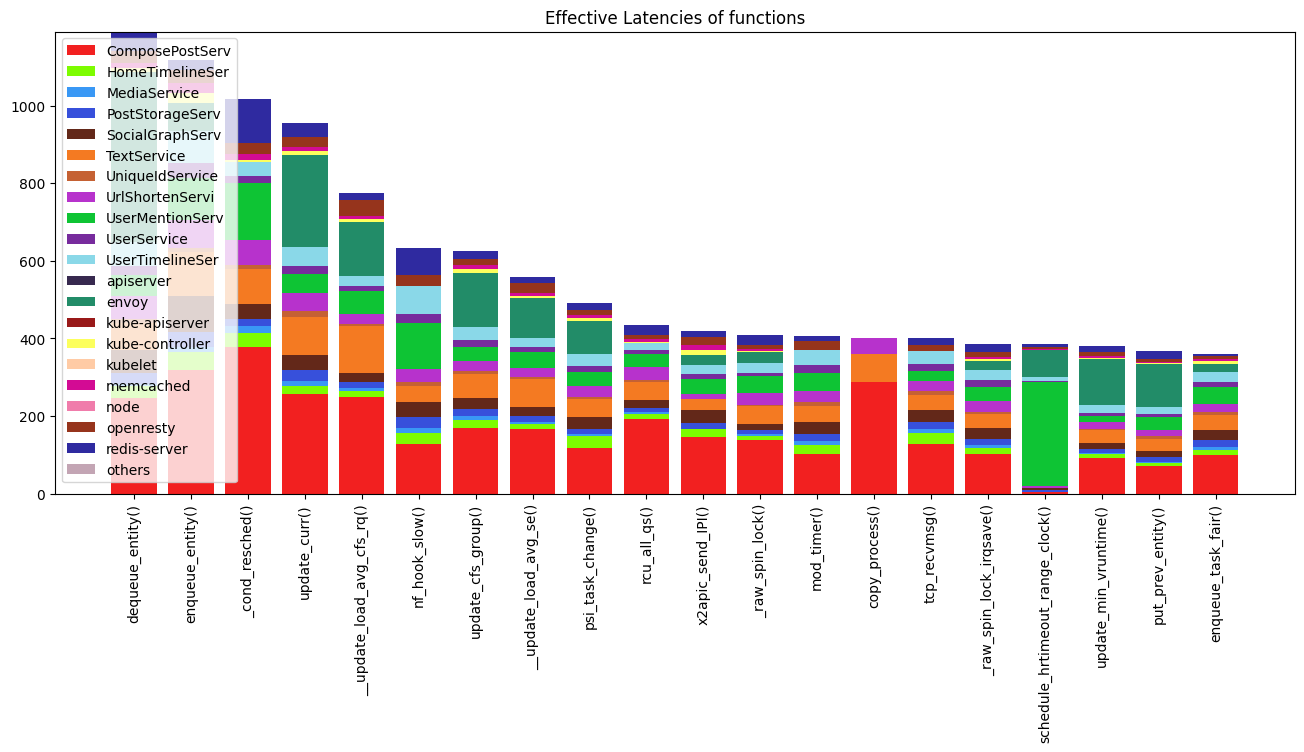

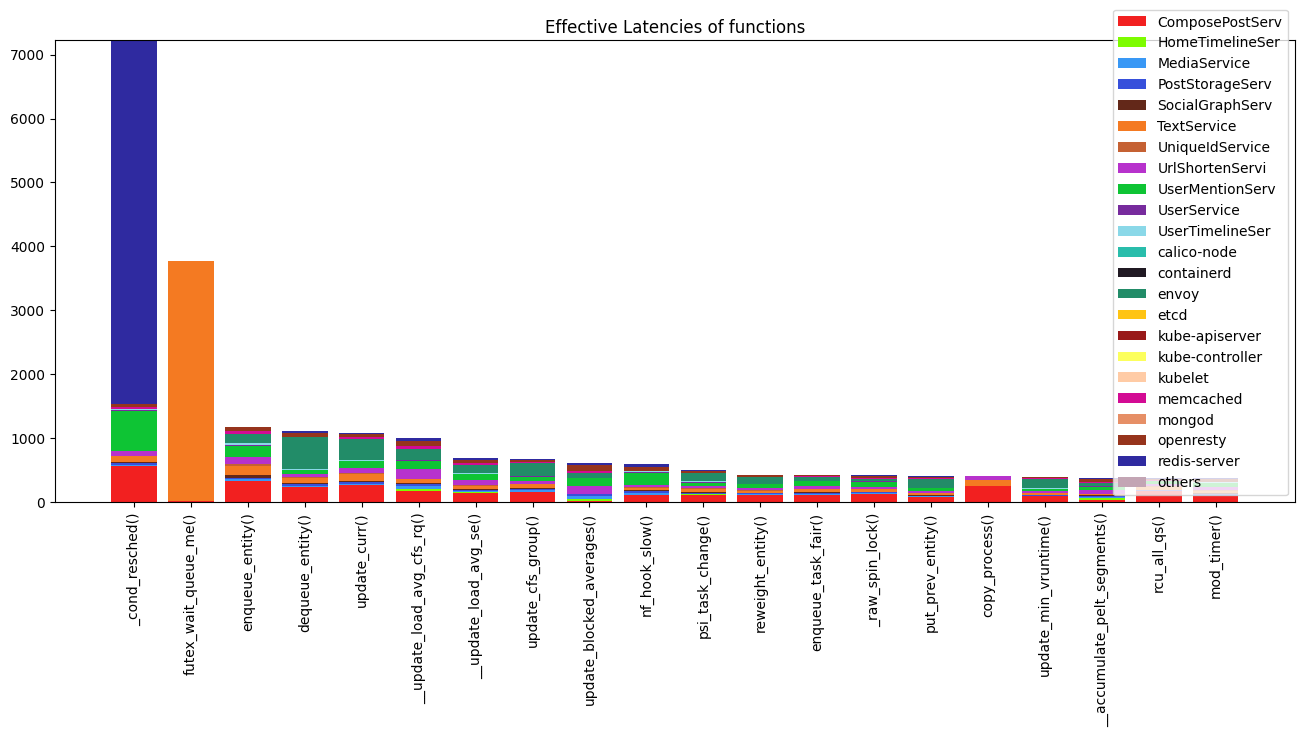

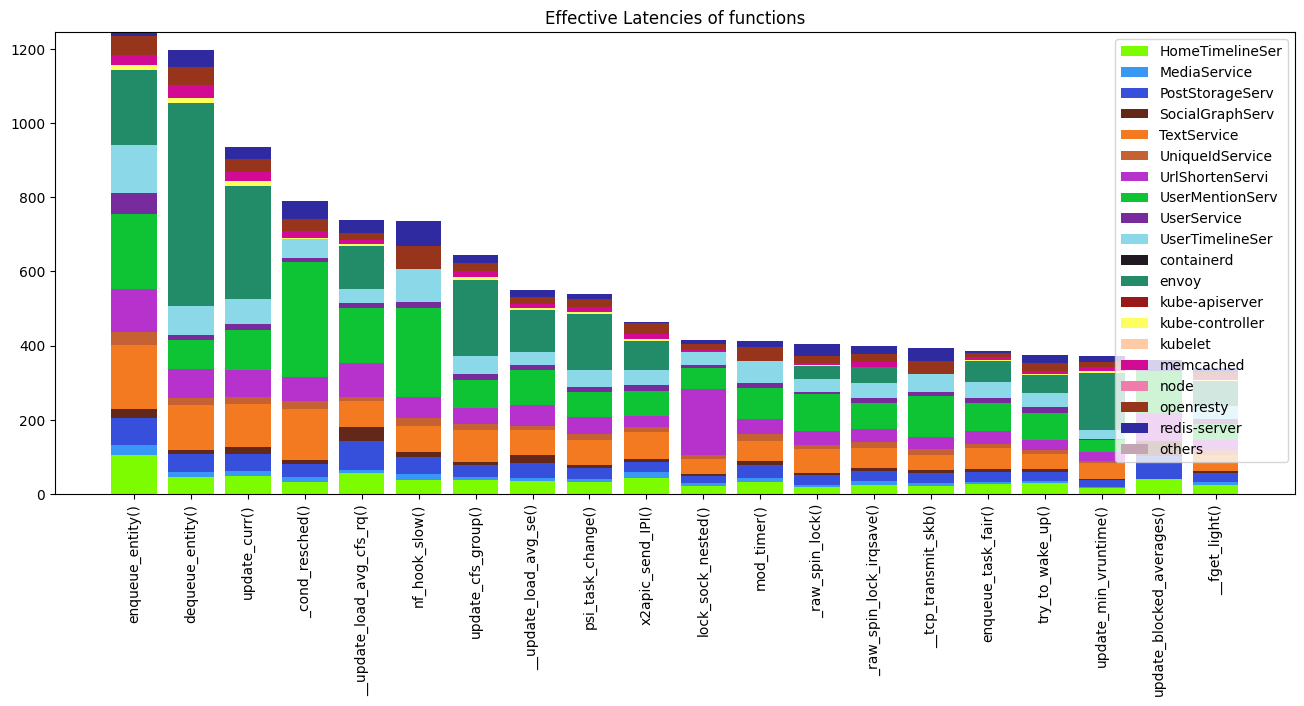

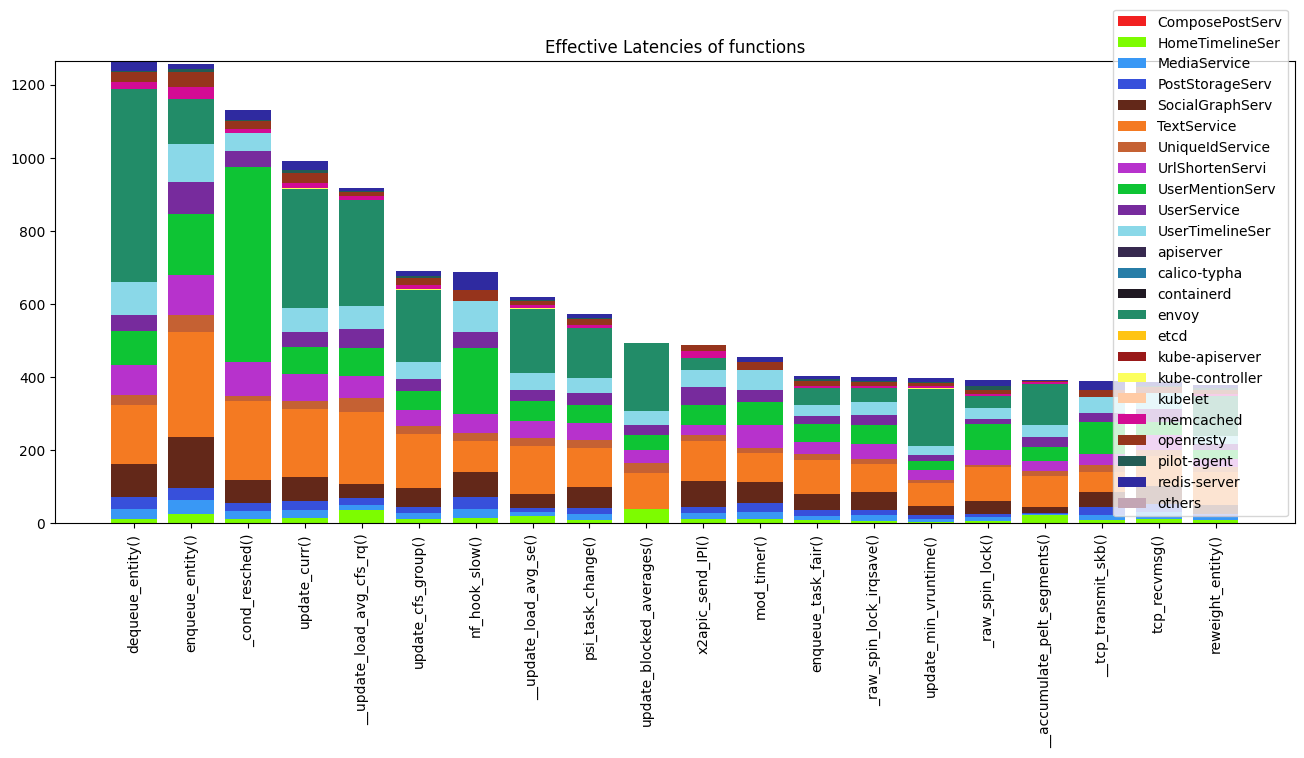

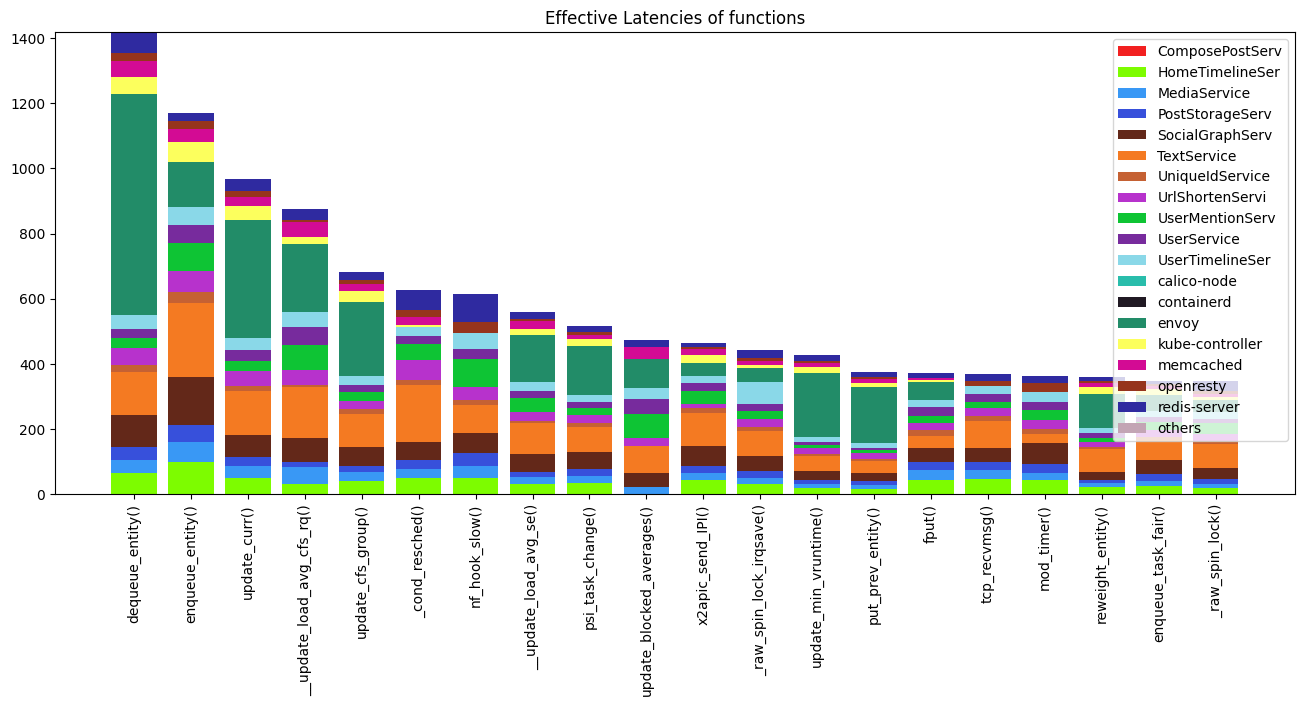

In [13]:
latencies = []
for i in range(NUM_RUNS):
    latencies.append(get_process_latency(runs[i],i))

for latency in latencies:
    plot_stacked_counts(latency, title="Effective Latencies of functions") # TODO: pick a better term

In [14]:
def get_pid_mapping(file):
    pid_mapping={}
    with open(file,'r') as f:
        for line in f.readlines():
            
            pid,*name= line.split()
            if(type(name)==list):
                name=' '.join(name)
            pid_mapping[pid]=name
            
    return pid_mapping

In [16]:

def get_latency_by_pid(run,function=None):
    latency = {}
    
    def update_latency(pid,data):
        
        for call in data:
            function_name = call['function_name']
            if (not function or function_name == function) and (function_name not in FUNC_BLACKLIST):              
                latency[pid] = latency.get(pid, 0) + call['time']
                
                for child in call['children']:
                    latency[pid] -= child['time']

            update_latency(pid,call['children'])
    
    for pid,data in run.items():
        update_latency(pid,data)

    return latency

In [17]:
cnt=[]
for i in range(NUM_RUNS):
    count={}
    pid_map=get_pid_mapping(f'{WORKLOAD}/{i}.saved_cmdlines')
    latency=(get_latency_by_pid(runs[i],'ipt_do_table [ip_tables]()'))
    for pid in latency.keys():
        if pid in pid_map:
            count[pid_map[pid]]=count.get(pid_map[pid],0)+latency[pid]
        else:
            cnt.append(pid)
    print(count)

{'UserMentionServ': 6.303000000000001}
{'UserMentionServ': 19.427999999999997, 'openresty': 19.712000000000003}
{'UserMentionServ': 22.610000000000003}
{'UserMentionServ': 14.885000000000003}
{'UserMentionServ': 5.738999999999998}


In [31]:
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()"}

def get_latency_by_pid(run,function=None):
    latency = {}
    
    def update_latency(pid,data):
        
        for call in data:
            function_name = call['function_name']
            if (not function or function_name == function) and (function_name not in FUNC_BLACKLIST):              
                latency[pid] = latency.get(pid, 0) + call['time']
                for child in call['children']:
                    latency[pid] -= child['time']

            update_latency(pid,call['children'])
    
    for pid,data in run.items():
        update_latency(pid,data)
        

    return latency

In [32]:
def plot_piechart(counts,title):
    count=counts.copy()
    todel=[]
    def percent(pct):
        if pct>0.5:
            return "{:1.3f}%".format(pct)
        else:
            return ""
    count['others']=0
    print(sum(count.values()))
    for p,latency in count.items():
        percentage_latency=(latency/sum(count.values()))*100
        if percentage_latency<1 and p!='others':
            count['others']=count.get('others',0)+latency
            todel.append(p)
    for i in todel:
        count.pop(i)
    # print(title)
    plt.figure(figsize=(6, 4))
    plt.pie(count.values(),labels=count.keys(),autopct=percent,radius=2,center=(0,2))
    plt.title(title,pad=100)
    plt.show()

0
{'TextService': 81661.84099999997, 'ComposePostServ': 136746.65000000005, 'envoy': 552996.573, 'UserService': 76750.75599999996, 'kube-controller': 47102.66399999999, 'kubelet': 4.009, 'kube-apiserver': 4.006, 'UrlShortenServi': 51114.14200000002, 'memcached': 45062.46199999999, 'wrk:worker_1': 13.035, 'redis-server': 124506.66399999999, 'ksoftirqd/3': 0.511, 'kworker/3:3': 1.222, 'UserTimelineSer': 48941.33400000001, 'wrk:worker_0': 14.286, 'UserMentionServ': 35679.75300000003, 'dog:workers_gua': 1.242, 'HomeTimelineSer': 48731.94800000001, 'SocialGraphServ': 50715.960000000036, 'PostStorageServ': 45581.71299999998, 'openresty': 36508.86399999999, 'MediaService': 30076.841999999997, 'UniqueIdService': 30039.715, 'apiserver': 0.662, 'Backgro.kSource': 2.0140000000000002, 'ksoftirqd/0': 0.381, 'ksoftirqd/6': 0.501, 'ksoftirqd/2': 0.29, 'ksoftirqd/5': 0.4, 'node': 0.822}
1442261.262


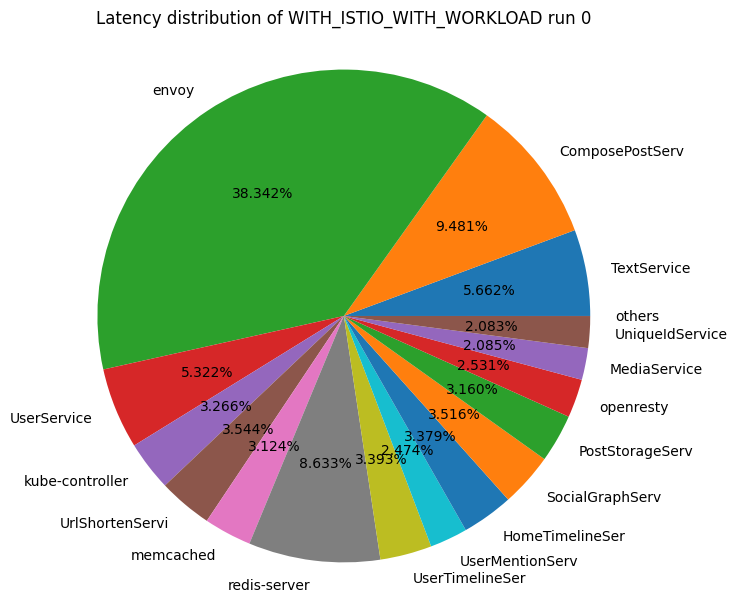

1
{'ComposePostServ': 143560.208, 'UniqueIdService': 51720.013000000006, 'UserMentionServ': 61134.33700000006, 'wrk:worker_0': 21.863, 'PostStorageServ': 49134.232000000025, 'envoy': 606537.1069999998, 'mongod': 1.393, 'TextService': 84851.95400000003, 'UrlShortenServi': 78681.631, 'HomeTimelineSer': 406.87600000000026, 'rcu_sched': 0.21, 'MediaService': 53558.979, 'ksoftirqd/7': 0.481, 'redis-server': 83238.07599999997, 'SocialGraphServ': 29331.176999999996, 'openresty': 66218.359, 'wrk:worker_1': 26.387999999999998, 'kube-apiserver': 0.21, 'UserTimelineSer': 16348.101, 'memcached': 54918.238999999994, 'kworker/1:2': 0.641, 'UserService': 35966.64900000002, 'ksoftirqd/4': 0.441, 'etcd': 3.136, 'kworker/2:5': 0.26, 'kubelet': 25.266000000000002, 'containerd': 25.672, 'kworker/5:1H': 2.054, 'dog:main_thread': 6.212, 'dog:workers_gua': 8.554, 'AccessLogFlush': 0.361, 'calico-node': 0.841, 'kube-controller': 49.63099999999999, 'kworker/u16:0': 0.341, 'kworker/6:0': 0.24}
1415780.133000000

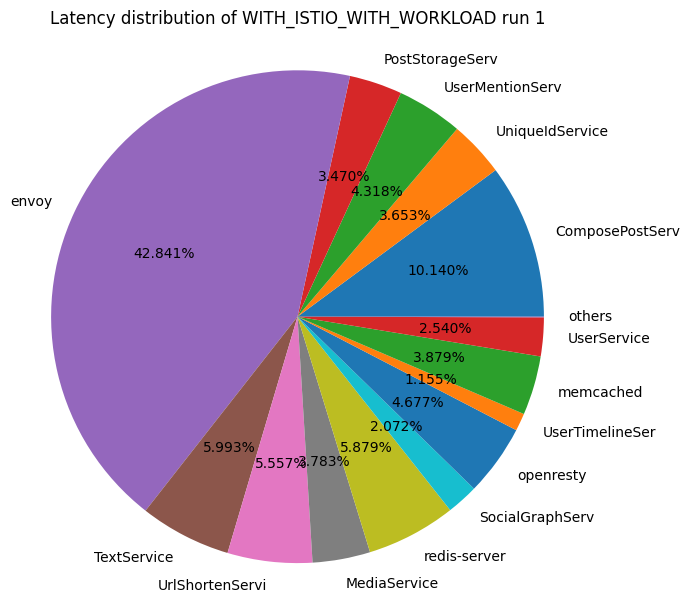

2
{'UrlShortenServi': 71756.965, 'UserMentionServ': 69357.73200000008, 'ksoftirqd/6': 2.525, 'envoy': 564490.8910000001, 'SocialGraphServ': 15037.974999999997, 'UniqueIdService': 61291.74400000001, 'TextService': 133354.491, 'conn12': 1.873, 'kubelet': 4.798, 'redis-server': 121099.18800000002, 'UserTimelineSer': 79276.77400000002, 'dog:main_thread': 3.075, 'wrk:worker_1': 10.83, 'PostStorageServ': 76900.42200000004, 'dog:workers_gua': 3.7270000000000003, 'openresty': 74202.61300000003, 'UserService': 45740.21100000002, 'wrk:worker_0': 10.018, 'memcached': 65544.52899999998, 'HomeTimelineSer': 64802.06399999997, 'MediaService': 45541.381000000016, 'kube-controller': 24537.05799999999, 'node': 0.801, 'sshd': 1.653, 'containerd-shim': 3.737, 'kube-apiserver': 1.122, 'kworker/0:0': 0.22, 'containerd': 2.495, 'ksoftirqd/2': 1.093, 'ksoftirqd/1': 0.36, 'Backgro.kSource': 2.224, 'rcu_sched': 1.964, 'ksoftirqd/3': 0.311}
1512986.8640000005


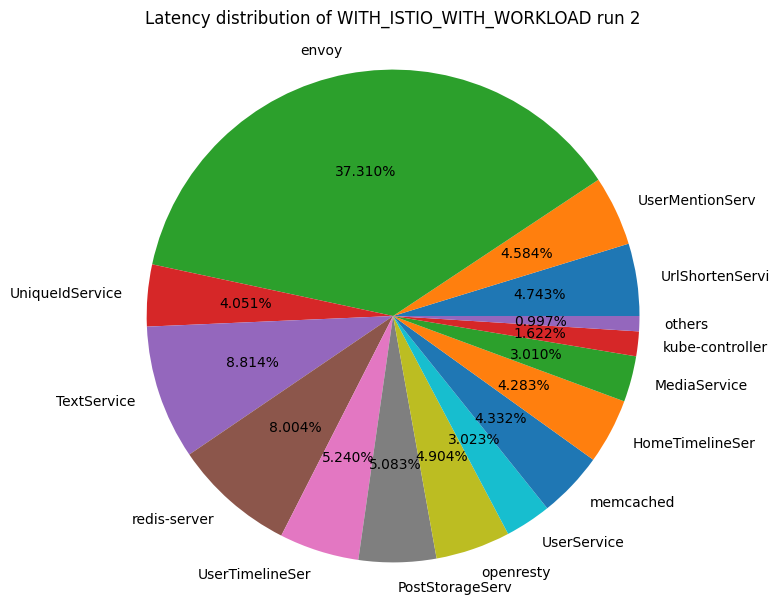

3
{'envoy': 1363116.8780000003, 'UniqueIdService': 55140.751, 'wrk:worker_0': 9.907, 'TextService': 167634.7299999999, 'redis-server': 66746.973, 'SocialGraphServ': 78622.71800000004, 'UserService': 121144.33499999998, 'PostStorageServ': 40026.538000000015, 'MediaService': 68970.83300000004, 'wrk:worker_1': 15.117, 'jbd2/vda1-8': 2.746, 'UrlShortenServi': 68753.61900000002, 'UserTimelineSer': 75973.35599999997, 'dog:workers_gua': 1.923, 'kube-controller': 5092.161, 'memcached': 35825.333999999995, 'UserMentionServ': 60330.92800000001, 'kubelet': 7.694, 'openresty': 29510.936999999987, 'ksoftirqd/0': 0.4, 'HomeTimelineSer': 18639.278999999995, 'ksoftirqd/5': 0.28, 'containerd': 7.405000000000001, 'kworker/3:1H': 0.25, 'etcd': 6.101, 'kube-apiserver': 2.235, 'ComposePostServ': 0.852, 'apiserver': 5.51, 'containerd-shim': 4.868, 'wrk': 1.563, 'kworker/u16:0': 1.743, 'runc': 4.519, 'pilot-agent': 183.48499999999993, 'calico-typha': 0.731}
2255786.698999998


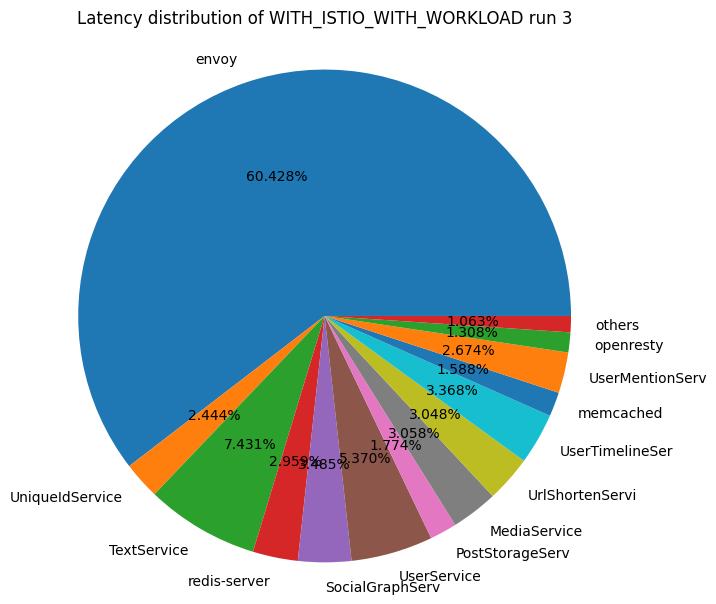

4
{'SocialGraphServ': 57509.95599999999, 'envoy': 814042.8540000002, 'UserService': 78275.87700000001, 'MediaService': 90739.989, 'ksoftirqd/1': 2.335, 'memcached': 69395.268, 'TextService': 122358.71699999999, 'UrlShortenServi': 21587.627999999993, 'ksoftirqd/3': 0.311, 'wrk:worker_1': 20.91, 'UserTimelineSer': 37966.340999999986, 'PostStorageServ': 52155.62300000002, 'HomeTimelineSer': 81971.60200000001, 'redis-server': 148429.44499999995, 'kube-controller': 77768.25699999991, 'UniqueIdService': 53241.939, 'UserMentionServ': 26675.447999999982, 'ksoftirqd/6': 1.693, 'ComposePostServ': 2.244, 'wrk:worker_0': 7.255, 'wrk:worker_5': 0.962, 'ksoftirqd/7': 0.29, 'calico-node': 1.483, 'openresty': 26904.184999999998, 'kworker/0:0': 1.162, 'containerd-shim': 1.513, 'ksoftirqd/5': 0.351, 'dog:main_thread': 1.002, 'containerd': 1.884, 'kworker/1:2': 0.221}
1759066.7449999999


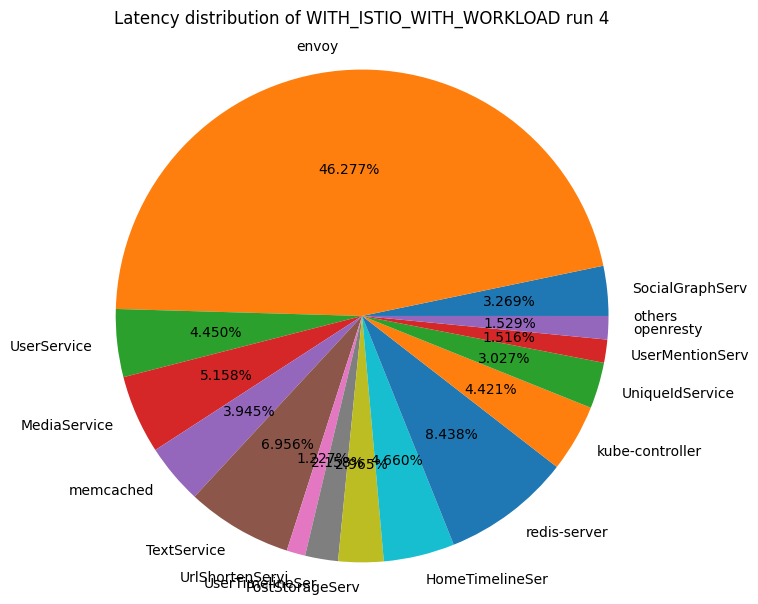

In [37]:
final_latency={}
counts={}
for i in range(NUM_RUNS):
    print(i)
    count={}
    pid_map=get_pid_mapping(f'{WORKLOAD}/{i}.saved_cmdlines')
    latency=(get_latency_by_pid(runs[i]))
    # print(latency)
    for pid in latency.keys():
        if pid in pid_map:
            count[pid_map[pid]]=count.get(pid_map[pid],0)+latency[pid]
    print(count)
    for key,val in count.items():
        if key in final_latency:
            final_latency[key]+=val
            counts[key]+=1
        else:
            final_latency[key]=val
            counts[key]=1
    # print(count)
    plot_piechart(count,f"Latency distribution of {WORKLOAD} run {i}")

for k,v in final_latency.items():
    final_latency[k]=(final_latency[k]/counts[k])

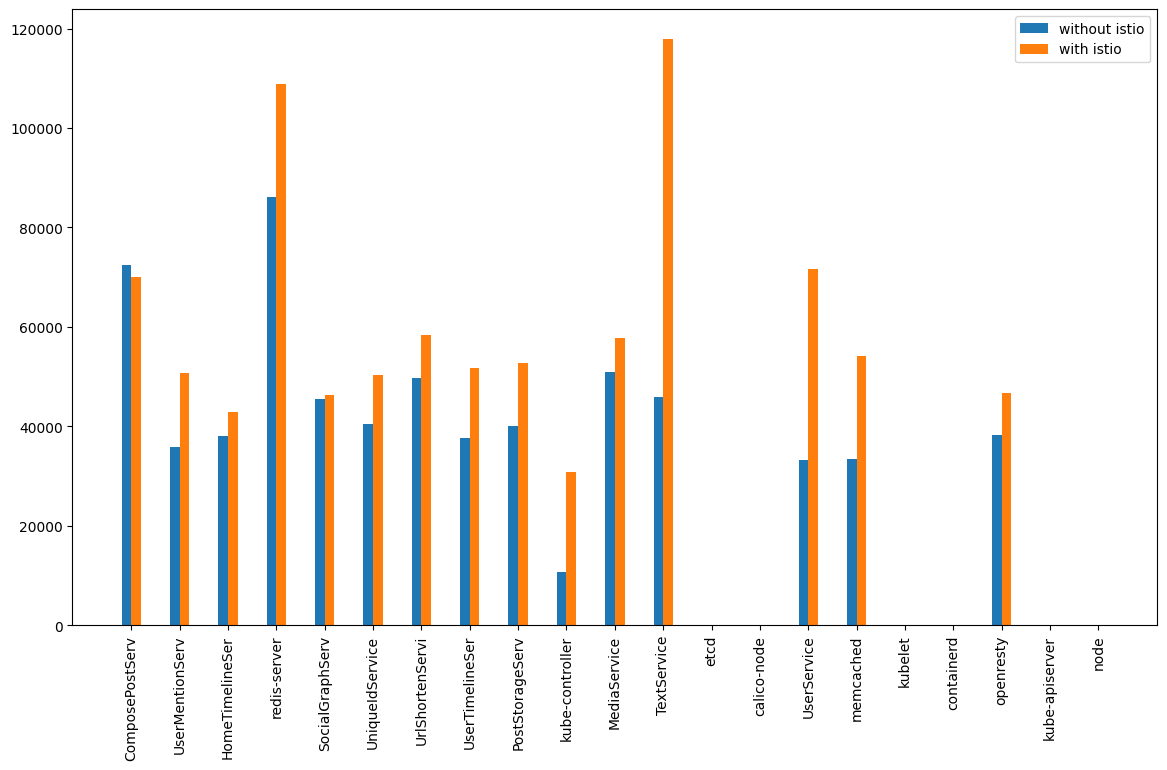

In [40]:
without_istio={'ComposePostServ': 72540.2154, 'UserMentionServ': 35861.095599999986, 'HomeTimelineSer': 38113.8062, 'redis-server': 86024.3686, 'SocialGraphServ': 45462.28159999999, 'UniqueIdService': 40516.37619999999, 'UrlShortenServi': 49783.8238, 'ksoftirqd/5': 0.23550000000000001, 'ksoftirqd/3': 0.34400000000000003, 'kworker/5:1': 0.7946666666666665, 'UserTimelineSer': 37607.1672, 'ksoftirqd/7': 0.7615000000000001, 'conn2': 2.40425, 'PostStorageServ': 40159.27479999999, 'kube-controller': 10805.642666666665, 'MediaService': 50842.55299999999, 'TextService': 45940.15599999999, 'ksoftirqd/6': 0.27549999999999997, 'kworker/1:1': 0.6743333333333333, 'ksoftirqd/4': 1.0370000000000001, 'ksoftirqd/1': 0.403, 'etcd': 3.0155000000000003, 'calico-node': 2.8623333333333334, 'UserService': 33235.614799999996, 'memcached': 33491.4136, 'Backgro.kSource': 1.09975, 'kubelet': 8.552333333333333, 'containerd': 6.846333333333334, 'ksoftirqd/2': 0.27, 'openresty': 38363.164399999994, 'operator': 0.851, 'kworker/2:0': 0.2555, 'kworker/u16:2': 0.7010000000000001, 'ksoftirqd/0': 0.28733333333333333, 'kworker/7:0': 0.3305, 'containerd-shim': 0.9283333333333333, 'wrk': 2.0635000000000003, 'kube-apiserver': 4.543000000000001, 'coredns': 1.052, 'runc': 3.017, 'kworker/3:1': 0.37, 'rcu_sched': 1.3230000000000002, 'runc:[2:INIT]': 7.432, 'node': 3.8915000000000006, 'kworker/6:1': 0.27, 'migration/4': 1.694}
with_istio = final_latency
proc=[]
withoutIstio=[]
withIstio=[]
for i in without_istio:
    if i in with_istio and i in PROCESSES:
        proc.append(i)
        withoutIstio.append(without_istio[i])
        withIstio.append(with_istio[i])
x = np.arange(len(proc))
plt.figure(figsize=(14, 8))
plt.bar(x-0.1, withoutIstio,0.2)
plt.bar(x+0.1, withIstio,0.2)
plt.xticks(x,proc,rotation=90)
plt.legend(['without istio','with istio'])


##### It is evident that Istio adds overhead to all the processes